In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

from qnorm import quantile_normalize

from tsa.preprocessing import get_sample_info, tpm_normalization, merge_replicates
from tsa.gpr import gpr
from tsa.gene_selection import score_normalization, plot_scores, best_n_genes
from tsa.clustering import cluster_genes
from tsa.alignment import time_series_alignment, best_alignment_graph, get_cost_matrix, plot_alignment
from tsa.utils import inference_timeseries, all_numeric, list2floats

plt.rcParams['figure.figsize'] = [8, 6]

### files

In [2]:
template_samples_file = "data/white_mpf_samples.tsv"
template_gpr_inference_file = "data/white_mpf_gpr.tsv"
template_gpr_scores_file = "data/white_mpf_score.tsv"

query_samples_file = "data/owensA1_mpf_samples.tsv"
query_gpr_inference_file = "data/owensA1_mpf_gpr.tsv"
query_gpr_scores_file = "data/owensA1_mpf_score.tsv"

orthologs_file = "orthologs/DR_XT_orthologs.tsv"

### Template preprocessing

In [3]:
# preprocessing
template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
template_sample_order, template_time2samples = get_sample_info(template_samples)

# gpr
template_tpms_inf = pd.read_csv(template_gpr_inference_file, sep="\t", index_col=0)
template_gpr_scores = pd.read_csv(template_gpr_scores_file, sep="\t", index_col=0)

extended_timepoints = list2floats(template_tpms_inf.columns)

# Template gene selection

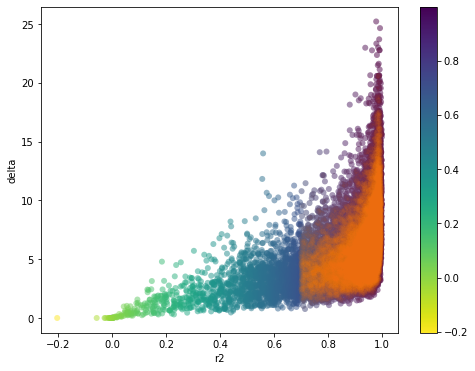

In [4]:
# remove genes that weren't modelled accurately
weight_expr=0
min_r2 = 0.7
weight_r2=1

template_gpr_scores.dropna(inplace=True)
gpr_normscores = score_normalization(template_gpr_scores, weight_expr, weight_r2)
top_template_genes = gpr_normscores[gpr_normscores.r2 >= min_r2].index.to_list()
plot_scores(gpr_normscores, highlight_top_n=len(top_template_genes))

# n = 12_000
# top_template_genes = best_n_genes(gpr_normscores, n)
# gpr_normscores = score_normalization(gpr_scores, weight_expr=1, weight_r2=3)
# plot_scores(gpr_normscores, highlight_top_n=n)

### Query preprocessing

#### option 1: GPR inferred

In [5]:
# preprocessing
query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
query_sample_order, query_time2samples = get_sample_info(query_samples)

# gpr
query_tpms_inf = pd.read_csv(query_gpr_inference_file, sep="\t", index_col=0)
query_gpr_scores = pd.read_csv(query_gpr_scores_file, sep="\t", index_col=0)

query_extended_timepoints = list2floats(query_tpms_inf.columns)

# Query gene selection

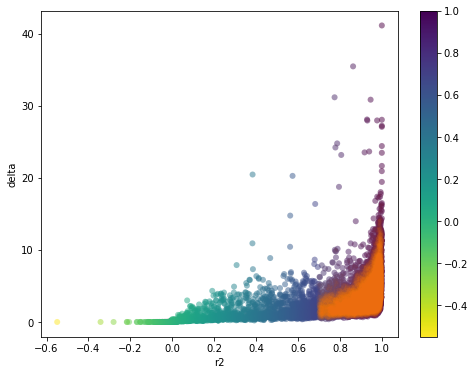

In [6]:
# remove genes that weren't modelled accurately
weight_expr=0
min_r2 = 0.7
weight_r2=1

query_gpr_scores.dropna(inplace=True)
query_gpr_normscores = score_normalization(query_gpr_scores, weight_expr, weight_r2)
top_query_genes = query_gpr_normscores[query_gpr_normscores.r2 >= min_r2].index.to_list()
plot_scores(query_gpr_normscores, highlight_top_n=len(top_query_genes))

# n = 12_000
# top_template_genes = best_n_genes(gpr_normscores, n)
# gpr_normscores = score_normalization(gpr_scores, weight_expr=1, weight_r2=3)
# plot_scores(gpr_normscores, highlight_top_n=n)

#### option 2: raw

In [7]:
# preprocessing
query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
query_sample_order, query_time2samples = get_sample_info(query_samples)

tpm_file = "data/XT9.1-TPM.tsv"
tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)
query_tpms = tpm_normalization(tpms, query_sample_order, min_value=5, min_median_value=0)

# merge replicates (if any)
query_tpms = merge_replicates(query_tpms, query_time2samples, how="mean")

if all_numeric(query_time2samples):
    # convert time to numeric
    samples2time = query_samples.to_dict()["time"]
    query_tpms = query_tpms.rename(columns=samples2time)

# replicate the other output
top_query_genes = query_tpms.index.to_list()
query_tpms_inf = query_tpms
query_extended_timepoints = list2floats(query_tpms_inf.columns)

query_tpms.head(3)

6607 genes with max below 5 TPM (31%)
313 genes with median below or equal to 0 TPM (2%)
14159 genes, 53 samples left after filtering


,240,270,300,330,360,390,420,450,480,510,...,1620,1680,1740,1800,1860,1920,1980,2040,2100,2160
gene,,,,,,,,,,,,,,,,,,,,,
ENSXETG00000000002,6.131145,5.921640,5.998804,6.173674,6.119142,6.259830,6.370552,6.320937,6.400027,6.237597,...,5.490205,5.543036,5.546245,5.679767,5.636308,5.700778,5.943369,5.930271,5.645986,5.643494
ENSXETG00000000003,6.111369,6.290138,6.274922,6.228988,6.207515,6.132275,6.137256,5.965053,5.854107,5.922741,...,5.061129,4.948665,5.032481,4.139545,4.887050,4.604822,3.982709,4.210871,4.935422,4.906007
ENSXETG00000000004,4.212082,4.236750,4.049790,3.841060,3.684565,3.447427,3.320187,3.418296,3.336306,3.648000,...,3.623838,3.655968,3.703871,3.500498,3.397711,3.481193,3.148725,3.249156,3.184631,3.197012


# Ortholog selection

In [8]:
# get all 1:1 orthologue genes (obtained from BIOMART)
df = pd.read_csv(
    orthologs_file, 
    sep="\t", 
    dtype=str, 
    usecols=[
        "Gene stable ID",
        "Gene name",
        "Tropical clawed frog gene stable ID",
        "Tropical clawed frog gene name",
        "Tropical clawed frog homology type"
    ]
)
df = df.rename(columns={
    "Tropical clawed frog gene name": "xt_name",
    "Tropical clawed frog gene stable ID": "xt_id",
    "Gene name": "dr_name",
    "Gene stable ID": "dr_id",
}, errors="raise")

# filter
df = df[df['Tropical clawed frog homology type'] == 'ortholog_one2one']
df = df[["dr_name", "dr_id", "xt_name", "xt_id"]]
df = df.dropna(subset=["xt_id", "dr_id"])
df = df.drop_duplicates()

orthologs = df.sort_values("dr_id", ignore_index=True)
del df

print(len(orthologs), "1:1 orthologs")
orthologs.head(3)

9453 1:1 orthologs


,dr_name,dr_id,xt_name,xt_id
0,slc35a5,ENSDARG00000000001,slc35a5,ENSXETG00000002426
1,nrf1,ENSDARG00000000018,nrf1,ENSXETG00000016306
2,ube2h,ENSDARG00000000019,ube2h,ENSXETG00000025415


In [9]:
print(len(top_template_genes), "template genes")
print(len(top_query_genes), "query genes")

df = orthologs.copy()
df = df[df.dr_id.isin(top_template_genes)]
df = df[df.xt_id.isin(top_query_genes)]

orto_dict = df[["dr_id", "xt_id"]].set_index("xt_id").to_dict()['dr_id']
starting_genes = list(orto_dict.values())

print(len(starting_genes), "overlapping genes")

17238 template genes
14159 query genes
3205 overlapping genes


### make datasets comparable
- sort genes
- use template gene IDs
- use template distribution

In [10]:
t = template_tpms_inf.loc[orto_dict.values()]

q = query_tpms_inf.loc[orto_dict.keys()]
q = q.rename(mapper=orto_dict)

target_distribution = t[t.columns[0]].to_list()
q = quantile_normalize(q, axis=1, target=target_distribution)

assert q.index.equals(t.index)
print(q.shape)
q.head(3)

(3205, 53)


,240,270,300,330,360,390,420,450,480,510,...,1620,1680,1740,1800,1860,1920,1980,2040,2100,2160
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000001,1.616313,1.666917,1.731745,1.926974,1.899061,2.109757,2.720661,3.087466,3.380715,3.716132,...,0.925942,0.968772,1.073346,1.407455,1.141887,1.047370,1.216935,1.011288,0.906049,0.918212
ENSDARG00000000018,3.646289,3.554294,3.473586,3.488392,3.572989,3.555718,3.554294,3.631970,3.466299,3.339225,...,2.632216,2.678586,2.691723,2.935965,2.603236,2.815741,2.755762,2.529866,2.529416,2.727692
ENSDARG00000000103,1.560941,1.949022,2.189963,2.437166,2.442653,2.940359,4.493859,5.167376,5.817882,5.871183,...,4.360568,4.627290,4.461162,4.739046,4.660465,4.587551,4.856900,4.467442,4.311887,4.438992


In [11]:
# # experiment: I think the XT dataset (query) might start earlier(!)
# q = q[q.columns[7:]]

# q.head(3)

# Gene clustering (optional)

In [12]:
# # set template_gene_clusters = None if clustering is not desired

# help(cluster_genes)

In [13]:
# for n in range(1, 16):
#     template_gene_clusters = cluster_genes(t, starting_genes, n)

# template_gene_clusters = cluster_genes(t, starting_genes, 15)

# TSA

In [14]:
# help(time_series_alignment)

In [15]:
# # find a showcase gene (expression pattern that can be compared visually)

# import sklearn
# import warnings

# plt.rcParams['figure.figsize'] = [24, 5]

# gene = q.sample(1).index[0]
# gene = "ENSDARG00000060070"
# for df in [t, q]:
#     x = list2floats(df.columns)
#     y = sklearn.preprocessing.scale(df.loc[gene])
#     plt.scatter(x, y)

# print(f'showcase_gene = "{gene}"')

# plt.rcParams['figure.figsize'] = [8, 6]

In [16]:
# # find the best metric

# showcase_gene = "ENSDARG00000060070"
# # showcase_gene = "ENSDARG00000036076"

# genes = [
#     "ENSDARG00000036076",
#     "ENSDARG00000060070",
#     'ENSDARG00000101735',
#     'ENSDARG00000034375',
# ]
# test = template_gene_clusters#.loc[genes] # template_gene_clusters
# test = None  # gene were already filtered
# # all: metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'jensenshannon', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'wminkowski', 'yule']
# # all working: metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'euclidean', 'jensenshannon', 'minkowski', 'seuclidean', 'sqeuclidean', 'yule']
# # all contenders: metrics = ['cityblock', 'correlation', 'minkowski', 'seuclidean', 'sqeuclidean']
# # serious contenders:
# metrics = ['cityblock', 'correlation', 'seuclidean']
# paths = []
# for metric in metrics:
#     print(metric)
#     try:
#         path = time_series_alignment(
#             t, q, test, cycles=1, n_clust=None, tries=100, ncpu=20, 
#             showcase_gene=showcase_gene, metric=metric)
#         paths.append(path)
#     except:
#         pass

In [17]:
# showcase_gene = "ENSDARG00000060070"
# # showcase_gene = "ENSDARG00000036076"

# # genes = [
# #     "ENSDARG00000036076",
# #     "ENSDARG00000060070",
# #     'ENSDARG00000101735',
# #     'ENSDARG00000034375',
# # ]
# # test = template_gene_clusters
# # test = template_gene_clusters.loc[genes]
# test = None
# paths = time_series_alignment(
#     t, q, test, cycles=3, tries=1000, ncpu=40, 
#     n_clust=None, n_total=None, frac=0.2,
#     showcase_gene=showcase_gene, metric='cityblock', 
#     filter_frac=0, top_frac=0.6, method="use_best",  # dont remove genes, just ignore the worst
# )

Cycle 1, using all 3205 genes.

	TSA of 100 alignments, 641 genes.


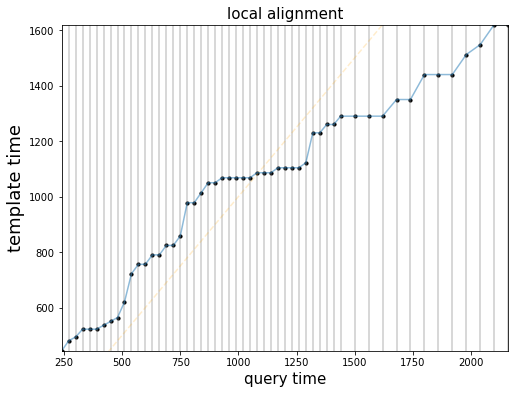

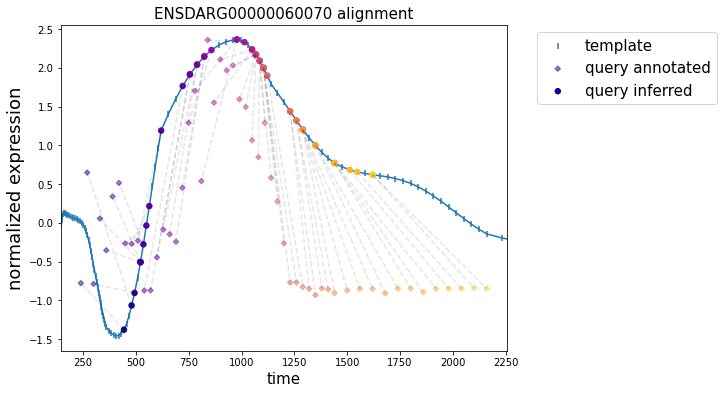

Cycle 2, using the best 2885 genes.

	TSA of 100 alignments, 577 genes.


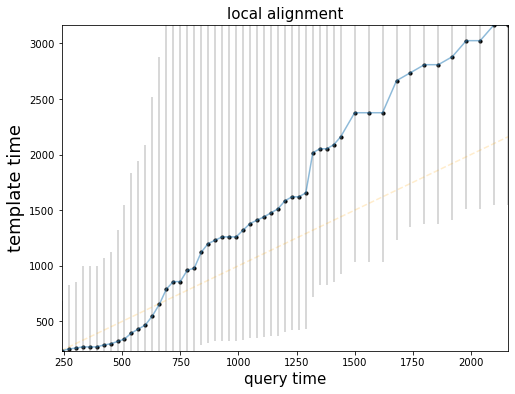

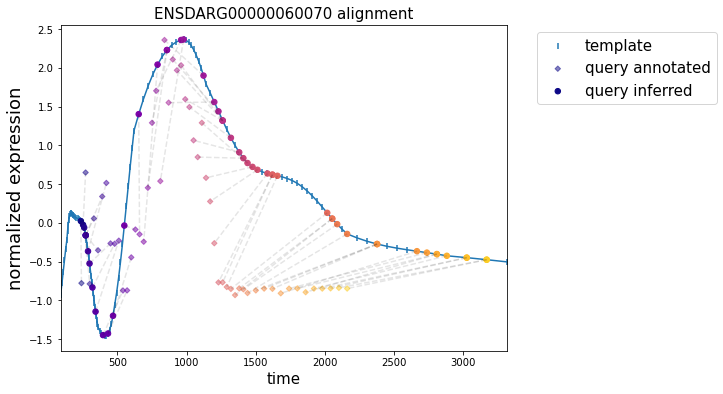

Cycle 3, using the best 2597 genes.

	TSA of 100 alignments, 519 genes.


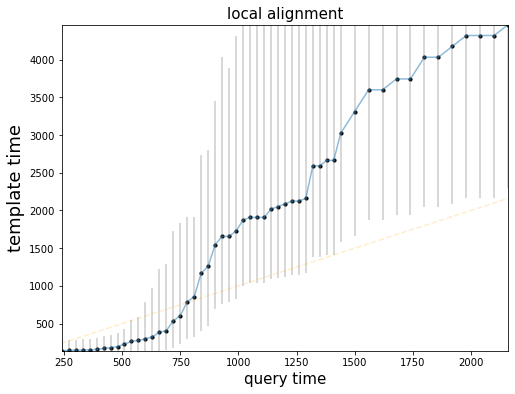

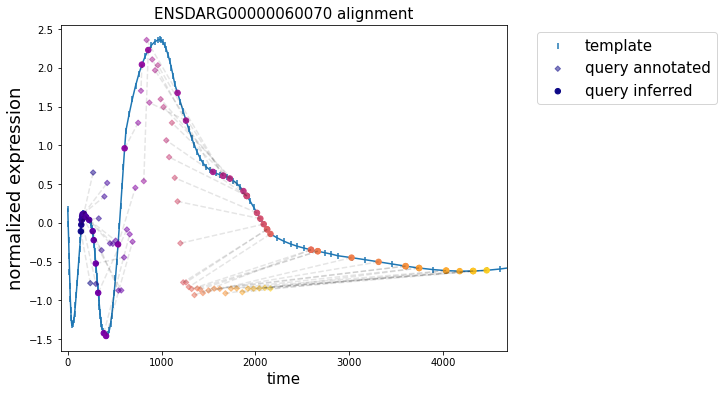

Cycle 4, using the best 2337 genes.

	TSA of 100 alignments, 467 genes.


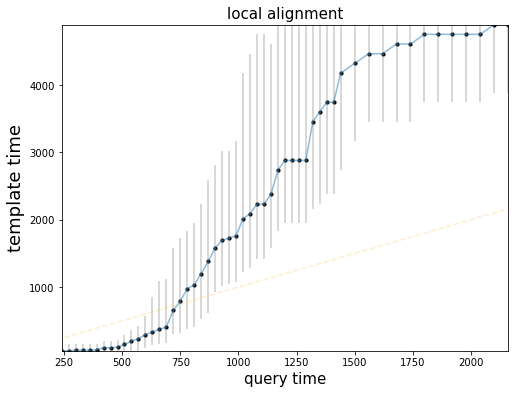

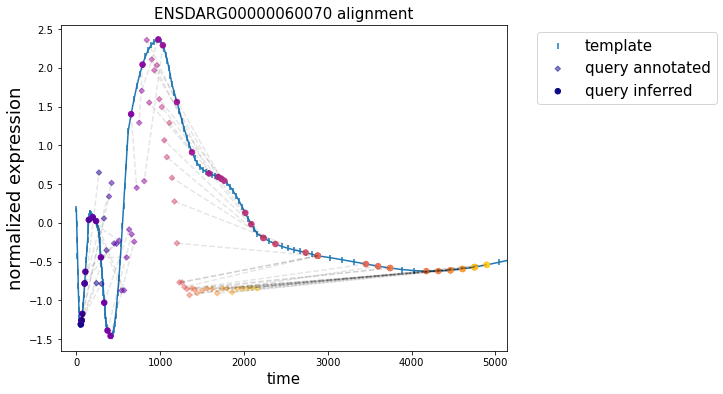

In [18]:
showcase_gene = "ENSDARG00000060070"

paths = time_series_alignment(
    t, q, None, cycles=4, tries=100, ncpu=40,
    n_clust=None, n_total=None, frac=0.2,
    showcase_gene=showcase_gene, #metric='cityblock', 
    shrink_rate=0.9,
#     filter_frac=0, top_frac=0.6, method="use_best",  # dont remove genes, just ignore the worst
)

In [19]:
# from tsa.alignment import plot_gene

# genes = [
#     "ENSDARG00000036076",
# # #     showcase_gene,
# #     "ENSDARG00000060070",
# #     'ENSDARG00000101735',
# # #     'ENSDARG00000057272',
# # #     'ENSDARG00000023290',
# # #     'ENSDARG00000079202',
# #     'ENSDARG00000034375',
# ]

# for n, path in enumerate(paths):
#     print("path", n)
#     for gene in genes:
# #         plot_gene(q, t, path, gene=gene, scale=False)
#         plot_gene(q, t, path, gene=gene, scale=True)
        

In [20]:
alignment_dir = "alignments"
t_fname = os.path.basename(template_samples_file).replace("_samples.tsv", "")
q_fname = os.path.basename(query_samples_file).replace("_samples.tsv", "")
alignment_file = os.path.join(alignment_dir, f"cross_species_{t_fname}_to_{q_fname}_alignment.tsv")


p = paths[-1]
query_time = list(query_time2samples)
mapped = pd.DataFrame(data={
    "annotated_time": query_extended_timepoints,
    "inferred_time": [extended_timepoints[i] for i in p],
#     "samples": query_time2samples.values(),
}).set_index("annotated_time")
# mapped["samples"] = mapped["samples"].astype(str)
# mapped.to_csv(alignment_file, sep="\t")
# print(f"saving mapping in '{alignment_file}'.")

# mapped = pd.read_csv(alignment_file, sep="\t", index_col=0)
mapped.head(3)

,inferred_time
annotated_time,
240.0,54.0
270.0,54.0
300.0,63.0


In [21]:
from tsa.utils import read_alignment

alignment_dir = "alignments"
t_fname = os.path.basename(template_samples_file).replace("_samples.tsv", "")
q_fname = os.path.basename(query_samples_file).replace("_samples.tsv", "")
alignment_file = os.path.join(alignment_dir, f"cross_species_{t_fname}_to_{q_fname}_alignment.tsv")

old = read_alignment(alignment_file)[0]
old

,inferred_time
annotated_time,
240.0,270.84
243.0,270.84
246.0,270.84
249.0,270.84
252.0,270.84
...,...
2136.0,5616.00
2142.0,5616.00
2148.0,5616.00


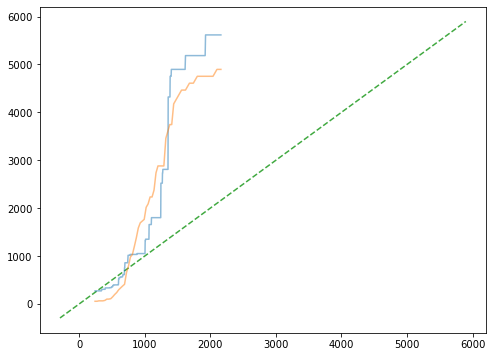

In [22]:
plt.rcParams['figure.figsize'] = [8, 6]
template_time = list2floats(template_time2samples)
# limit the plot to the range of the query series (plus padding)
start = template_time[0]
end = 0

for df in [old, mapped]:
    x = list2floats(df.index)  # annotated_time
    y = list2floats(df.inferred_time)
    plt.plot(x, y, alpha=0.5)
    
    # update the plot bounds
    end = max(end, y[-1]*1.05)
start = start - (end - start)*0.05

plt.plot([start, end], [start, end], label="if time annotations were perfect", alpha=0.9, ls='--', zorder=-10)

In [ ]:
template_time = list2floats(template_time2samples)

x = list2floats(mapped.index)  # annotated_time
y = list2floats(mapped.inferred_time)
end = y[-1]*1.05
start = max(x[0], template_time[0])
start = start - (end - start)*0.05

plt.rcParams['figure.figsize'] = [8, 6]
plt.plot(x, y, alpha=0.5)
plt.plot([start, end], [start, end], label="if time annotations were perfect", alpha=0.9, ls='--', zorder=-10)

In [ ]:
alignment_files =[
    'alignments/white_mpf_to_white_mpf_alignment.tsv',
    'alignments/cross_species_white_mpf_to_owensA1_mpf_alignment.tsv',
]

In [ ]:
from tsa.combine import plot_offset

# square image
plt.rcParams['figure.figsize'] = [10, 10]

template_time = list2floats(template_time2samples)
fname = None
# fname = "alignments/DR_white_mpf_MultiAlignment.pdf"
# fname = "alignments/XT_owensA1_mpf_MultiAlignment.pdf"
plot_offset(template_time, alignment_files, to_file=fname)

In [ ]:
from tsa.combine import plot_timeline

# wide image
plt.rcParams['figure.figsize'] = [24, 6]

template_time = list2floats(template_time2samples)
fname = None
# fname = "alignments/DR_white_mpf.pdf"
# fname = "alignments/XT_owensA1_mpf.pdf"
plot_timeline(template_time, extended_timepoints, alignment_files, to_file=fname)


### manual gene selection

In [ ]:
# orthologs[orthologs.xt_id == "ENSXETG00000019924"]

In [ ]:
# genes = list(tpms.index.unique())
genes = list(orthologs["dr_name"].unique())

In [ ]:
selected_genes_df = orthologs.copy().head(0)

In [ ]:
query = "hoxd10a"
hits = [g for g in genes if str(g).startswith(query)]
for hit in hits:
    print(df[df["dr_name"] == hit])

In [ ]:
selected_genes_df = pd.concat([selected_genes_df, df[df["dr_name"] == hit]])
selected_genes_df

In [ ]:
# selected_genes_dict["dr_name"].to_list()
# ['sox21b',
#  'foxb1a',
#  'eomesa',
#  'gata6',
#  'hoxa1a',
#  'hoxa2b',
#  'hoxa4a',
#  'hoxa5a',
#  'hoxa9a',
#  'hoxa10b',
#  'hoxa11a',
#  'hoxa13a',
#  'hoxd4a',
#  'hoxd9a',
#  'hoxd10a']

In [ ]:
hits = [
    'hoxa1a',
    'hoxa2b',
    'hoxa4a',
    'hoxa5a',
    'hoxa9a',
    'hoxa10b',
    'hoxa11a',
    'hoxa13a',
    'hoxd4a',
    'hoxd9a',
    'hoxd10a',
]

df = orthologs.copy()
hox_df = orthologs.copy().head(0)
for hit in hits:
    hox_df = pd.concat([hox_df, df[df["dr_name"] == hit]])
    
hox_df

In [ ]:
# selected_genes_df = hox_df

### dirty auto gene selection

In [ ]:

# orthologs = df
# orthologs = orthologs.drop_duplicates(["xt_id"])
# orthologs = orthologs.drop_duplicates(["dr_id"])
# orthologs = orthologs.sort_values("dr_id")


In [ ]:
# # keep only the first ortholog (dirty)
# df = orthologs.copy()
# df = df[~df["dr_id"].duplicated()]
# df = df[~df["xt_id"].duplicated()]
# df = df.sort_values("dr_id")
# selected_genes_df = df.sample(500)

# selected_genes_df

In [ ]:
# selected_genes_dict = {
#     # gene_names           foxa1                 sox21                 eomes                 gata6                 hoxa1               pou6f2
#     "xenopus":    ["ENSXETG00000017708", "ENSXETG00000010955", "ENSXETG00000019924", "ENSXETG00000003144", "ENSXETG00000000715", "ENSXETG00000005600"],
#     "zebrafish":  ["ENSDARG00000089042", "ENSDARG00000008540", "ENSDARG00000104243", "ENSDARG00000103589", "ENSDARG00000104307", "ENSDARG00000086362"],
# }

In [ ]:
# grcz11 = {
#     "ENSDARG00000070913": "sox2",
#     "ENSDARG00000044774": "oct4",
#     "ENSDARG00000102138": "foxa1",
#     "ENSDARG00000006640": "eomesa",
# #     "ENSDARG00000075113": "nanog",
#     "ENSDARG00000103589": "gata6",
#     "ENSDARG00000054033": "hoxb1b",
#     "ENSDARG00000070339": "hoxc3a",
#     "ENSDARG00000031246": "hbegfb",
# }
# xt91 = {
#     "ENSXETG00000036807": "sox2",
#     "ENSXETG00000026475": "oct4",  # pou5f3.1
#     "ENSXETG00000025867": "foxa1",
#     "ENSXETG00000019924": "eomesa",
# #     "": "nanog",
#     "ENSXETG00000003144": "gata6",
#     "": "hoxb1b",
#     "": "hoxc3a",
#     "": "hbegfb",
# }

In [ ]:
# template
tpm_file = "data/GRCz11-TPM.tsv"
template_samples_file = "data/white_mpf_samples.tsv"

template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(template_samples)

tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

# filter & order
template_tpms = tpms[sample_order]
# selected_genes = list(orthologs["dr_id"])
# selected_genes = selected_genes_dict["zebrafish"]
# selected_genes = selected_genes_df["dr_id"].to_list()
gene_order = orthologue_order["dr_id"].to_list()
template_tpms = template_tpms.loc[gene_order]

# average replicates
for timepoint in time2samples:
    template_tpms[timepoint] = template_tpms[time2samples[timepoint]].mean(axis=1)
template_tpms = template_tpms.filter(items=time2samples.keys())

template_tpms = template_tpms[template_tpms.max(axis=1) >= 5]  # filter genes

# quantile normalize & transform
template_tpms = quantile_normalize(template_tpms, axis=1)
template_tpms = np.log2(template_tpms+1)

template_tpms

In [ ]:
# query
tpm_file = "data/XT9.1-TPM.tsv"
query_samples_file = "data/owensA1_mpf_samples.tsv"

query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(query_samples)

tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

# filter & order
query_tpms = tpms[sample_order]
# selected_genes = list(orthologs["xt_id"])
# selected_genes = selected_genes_dict["xenopus"]
# selected_genes = selected_genes_df["xt_id"].to_list()
# df = selected_genes_df
# df = df[df["dr_id"].isin(template_tpms.index)]
# selected_genes = df["xt_id"].to_list()
df = orthologue_order
df = df[df["dr_id"].isin(template_tpms.index)]
selected_genes = df["xt_id"].to_list()
query_tpms = query_tpms.loc[selected_genes]

# average replicates
for timepoint in time2samples:
    query_tpms[timepoint] = query_tpms[time2samples[timepoint]].mean(axis=1)
query_tpms = query_tpms.filter(items=time2samples.keys())

# quantile normalize to the template distribution & transform
target_distribution = template_tpms[template_tpms.columns[0]].to_list()
query_tpms =quantile_normalize(query_tpms, axis=1, target=target_distribution)
query_tpms = np.log2(query_tpms+1)

query_tpms

In [ ]:
raw_template_tpms = template_tpms.copy()
raw_query_tpms = query_tpms.copy()

### filter geneset

In [ ]:
# keep only the first ortholog (dirty)
df = orthologs.copy()
df = df[~df["dr_id"].duplicated()]
df = df[~df["xt_id"].duplicated()]
df = df.sort_values("dr_id")
df = df[df["dr_id"].isin(raw_template_tpms.index)]
selected_genes_df = df#.sample(500)

selected_genes_df

In [ ]:
template_tpms = raw_template_tpms.copy()
query_tpms = raw_query_tpms.copy()

print(template_tpms.shape)
print(query_tpms.shape)

# df = hox_df[hox_df["dr_id"].isin(template_tpms.index)]
df = selected_genes_df#[selected_genes_df["dr_id"].isin(template_tpms.index)]

template_tpms = template_tpms[template_tpms.index.isin(df["dr_id"])]
query_tpms = query_tpms[query_tpms.index.isin(df["xt_id"])]

print(template_tpms.shape)
print(query_tpms.shape)

In [ ]:
# import seaborn as sns
cost_matrix = get_cost_matrix(template_tpms, query_tpms)#, "correlation")
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.heatmap(cost_matrix)


# https://stackoverflow.com/questions/31599602/how-to-plot-a-point-to-point-alignment-between-two-sequences-of-datapoints

## TSA

In [ ]:
# cost_matrix = get_cost_matrix(template_tpms, query_tpms)#, "correlation")

# LTSA
best_path, best_score = best_alignment_graph(cost_matrix)
plot_alignment(cost_matrix, best_path)

# mapping
query_time = list2floats(query_tpms.columns)
extended_template_time = list2floats(template_tpms.columns)
mapped = pd.DataFrame(data={
    "original_time": query_time,
    "inferred_time": [extended_template_time[i] for i in best_path],
})
alignment_file = "orthologs/dr_mpf_xt_mpf_sample_mapping.tsv"
mapped.to_csv(alignment_file, sep="\t", index=False)  # noqa

In [ ]:
# templtae vs template

cost_matrix = get_cost_matrix(template_tpms, template_tpms)#, "correlation")

# LTSA
best_path, best_score = best_alignment_graph(cost_matrix)
plot_alignment(cost_matrix, best_path)

# mapping
query_time = list2floats(template_tpms.columns)
extended_template_time = list2floats(template_tpms.columns)
mapped = pd.DataFrame(data={
    "original_time": query_time,
    "inferred_time": [extended_template_time[i] for i in best_path],
})
alignment_file = "orthologs/dr_mpf_dr_mpf_sample_mapping.tsv"
mapped.to_csv(alignment_file, sep="\t", index=False)  # noqa

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsa.utils import inference_timeseries


# universal zebrafish time axis (from ZFIN)
all_mpf = [
    0,
    45,
    60,
    75,
    90,
    105,
    120,
    135,
    150,
    165,
    180,
    200,
    220,
    240,
    260,
    280,
    315,
    340,
    360,
    480,
    540,
    600,
    620,
    700,
    840,
    960,
    1140,
    1320,
    1440,
    1800,
    2160,
    2520,
    2880,
    3600,
    4320,
    5760,
    7200,
    8640,
    10080,
    20160,
    30240,
    43200,
    64800,
][:-6]
all_stages = [
    "1-cell",
    "2-cell",
    "4-cell",
    "8-cell",
    "16-cell",
    "32-cell",
    "64-cell",
    "128-cell",
    "256-cell",
    "512-cell",
    "1k-cell",
    "High",
    "Oblong",
    "Sphere",
    "Dome",
    "30%-epiboly",
    "50%-epiboly",
    "Germ-ring",
    "Shield",
    "75%-epiboly",
    "90%-epiboly",
    "Bud",
    "1-4 somites",
    "5-9 somites",
    "10-13 somites",
    "14-19 somites",
    "20-25 somites",
    "26+ somites",
    "Prim-5",
    "Prim-15",
    "Prim-25",
    "High-pec",
    "Long-pec",
    "Pec-fin",
    "Protruding-mouth",
    "Day 4",
    "Day 5",
    "Day 6",
    "Days 7-13",
    "Days 14-20",
    "Days 21-29",
    "Days 30-44",
    "Days 45-89",
][:-6]


#########################################


# query alignments
alignment_files = {
    "Zebrafish": "orthologs/dr_mpf_dr_mpf_sample_mapping.tsv",
    "Frog": "orthologs/dr_mpf_xt_mpf_sample_mapping.tsv",
}

# output plot
plot_file = "orthologs/alignment_dr_xt_sample_orthologs.pdf"

fig = plt.figure(1,figsize = [24, 8])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

# ax1.grid(False)
# ax2.grid(False)

n = 0
ylabels = []
for series in alignment_files:
    df = pd.read_csv(alignment_files[series], sep="\t")
    x1 = df["original_time"]
    x2 = df["inferred_time"]
    plt.scatter(x=x1, y=np.zeros_like(x1) + n)
    n += 1
    plt.scatter(x=x2, y=np.zeros_like(x2) + n)
    n += 1
    ylabels.extend([f"{series} annotated", f"{series} inferred"])
    
    matches = zip(x1, x2)
    for i, j in matches:
        plt.plot((i, j), (n-2, n-1), color = 'black', alpha=0.1, linestyle='--')

# plot shape
x_axis = all_mpf[:-4]
x_labels1 = all_stages[:-4]
x_labels2 = all_mpf[:-4]
x_range = max(x_axis) - min(x_axis)
plt.yticks(list(range(n)), ylabels)
plt.ylim(-0.5, n - 0.5)
plt.ylabel("time series")

total_time = max(x_axis) - min(x_axis)
plt.xlim(min(x_axis) - x_range * 0.03, max(x_axis) + x_range * 0.03)
ax1.set_xlim(ax2.get_xlim())  # for some reason ax2 has the limits we need, but not ax1(?)

ax1.set_xticks(x_axis)
ax1.set_xticklabels(x_labels1, rotation=45, ha="right")
ax1.set_xlabel("developmental stage")

ax2.set_xticks(x_axis)
ax2.set_xticklabels(x_labels2, rotation=45, ha="left")
ax2.set_xlabel("minutes post fertilization")

plt.savefig(plot_file)
plt.show()